<a href="https://colab.research.google.com/github/Thinsheep/TrainingTrack/blob/main/Behavior_Cloning(Transform).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!git clone https://github.com/Thinsheep/TrainingTrack

fatal: destination path 'TrainingTrack' already exists and is not an empty directory.


In [34]:
!ls TrainingTrack

driving_log.csv  IMG


In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath # to working with the path
import random

In [36]:
datadir = 'TrainingTrack'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1) # to solve display overlapping
data.head() # to view the first five line of the frame

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\User\Desktop\TrainingData\IMG\center_2020_11_28_07_38_13_000.jpg  ...  19.68481
1  C:\Users\User\Desktop\TrainingData\IMG\center_2020_11_28_07_38_13_070.jpg  ...  19.52651
2  C:\Users\User\Desktop\TrainingData\IMG\center_2020_11_28_07_38_13_137.jpg  ...  19.40860
3  C:\Users\User\Desktop\TrainingData\IMG\center_2020_11_28_07_38_13_210.jpg  ...  19.25250
4  C:\Users\User\Desktop\TrainingData\IMG\center_2020_11_28_07_38_13_277.jpg  ...  19.13633

[5 rows x 7 columns]

In [37]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf) # we only show the tail of the link
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2020_11_28_07_38_13_000.jpg  ...  19.68481
1  center_2020_11_28_07_38_13_070.jpg  ...  19.52651
2  center_2020_11_28_07_38_13_137.jpg  ...  19.40860
3  center_2020_11_28_07_38_13_210.jpg  ...  19.25250
4  center_2020_11_28_07_38_13_277.jpg  ...  19.13633

[5 rows x 7 columns]

[  99    9    1   25   22   26   33   35   65   70   34   68 4247   90
   41   81   80   37   60   22   37   18    8   13   57]
[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


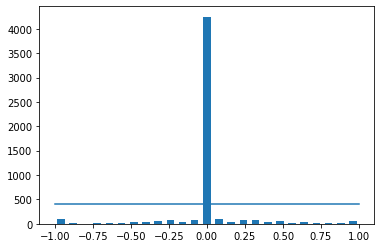

In [38]:
num_bins = 25 
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
#hist assigned to veritcal values and bins to horizontal values.
center = (bins[:-1] + bins[1:])*0.5
# we plus togther so it can cancel each other and become center value
# -0.92 + 0.92, -0.04 + 0.04, then it become double we need *0.5 to get back
print(hist)
print(bins)
plt.bar(center, hist, width= 0.05)
# the vertical axis is the frequency of steering, we most at the time in the 
# middle of the track
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
# we reject all samples that exceed 200, in this case is 0

total date 5278
removed 3847
remaining: 1431


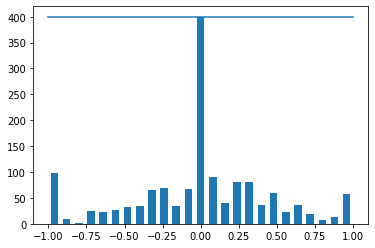

In [39]:
print('total date', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i]<= bins[j+1]:
      list_.append(i)
    # we try to combine neigbor values to the same bins, for example -0.97, -0.95
  list_ = shuffle(list_)# make sure equally cut data from begining to the end of track
  list_ = list_[samples_per_bin: ] # we cut from 200 to the end of the list
  remove_list.extend(list_)

print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace= True)
# inplace is to have all updated value remain on the same copy
# mean removing the gap when serveral steering positions are removed. 
print('remaining:', len(data))
    
hist, _ =np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width= 0.05)
# the vertical axis is the frequency of steering, we most at the time in the 
# middle of the track
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
# we reject all samples that exceed 200, in this case is 0

In [40]:
# our data seem not to be well balance but we take care of it later.
# now we split the training and validation data
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    #.strip help to remove all the space in the link
    steering.append(float(indexed_data[3]))
    # the position of steering is position 3 in the data.iloc
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
  
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2020_11_28_07_38_13_902.jpg
left        left_2020_11_28_07_38_13_902.jpg  
right       right_2020_11_28_07_38_13_902.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       17.9437                           
Name: 13, dtype: object


In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size =0.2, random_state=6)
# random_state, random the way data split 
print('Training samples:{} \n Valid sample {} '.format(len(X_train), len(X_valid)))

Training samples:1144 
 Valid sample 287 


Text(0.5, 1.0, 'Validation_set')

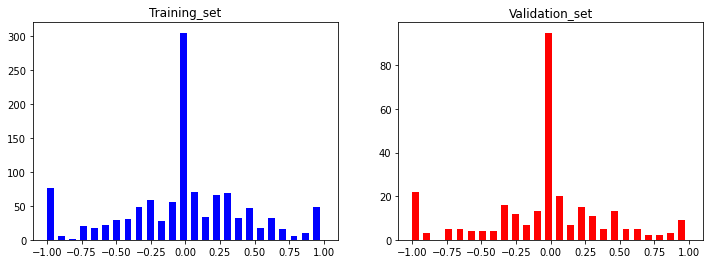

In [42]:
# Now make sure both dataset include uniform distribution dataset.
fig, axs = plt.subplots(1, 2, figsize =(12,4))
axs[0].hist(y_train, bins=num_bins, width=0.05, color ='blue')
axs[0].set_title('Training_set')
axs[1].hist(y_valid, bins=num_bins, width=0.05, color ='red')
axs[1].set_title('Validation_set')


In [43]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image


Text(0.5, 1.0, 'Zoomed Image')

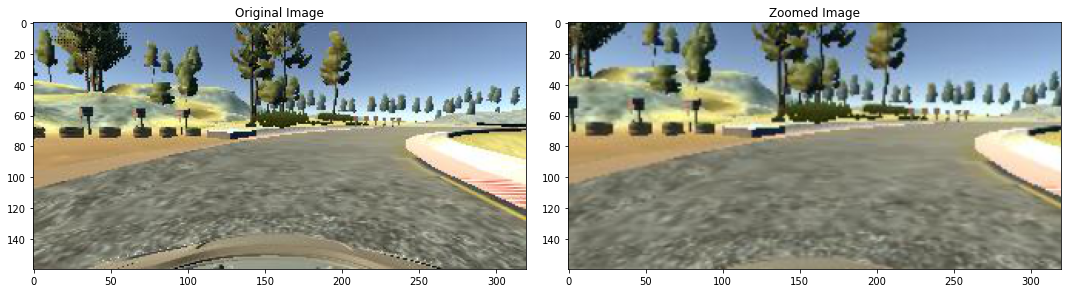

In [44]:
image = image_paths[random.randint(0, 1000)]
origional_image = mpimg.imread(image)
zoomed_image = zoom(origional_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10)) # 1 row 2 columns
fig.tight_layout()
axs[0].imshow(origional_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [45]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
  # select random percentage according our range
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

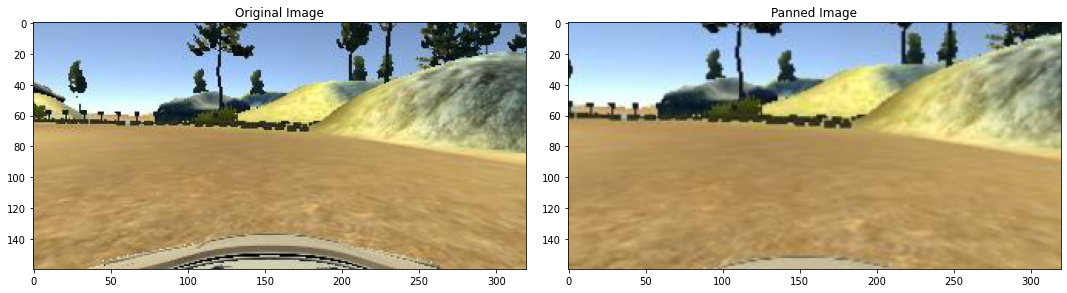

In [46]:
image = image_paths[random.randint(0, 1000)]
origional_image = mpimg.imread(image)
panned_image = zoom(origional_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10)) # 1 row 2 columns
fig.tight_layout()
axs[0].imshow(origional_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')
# This actually shifts the image

In [47]:
# now we want to adjust the brightness
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))# multply the pixel in the image with random value. 
  #0.2 and 1.2 to make the image darker, darker is better than brighter
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness altered Image')

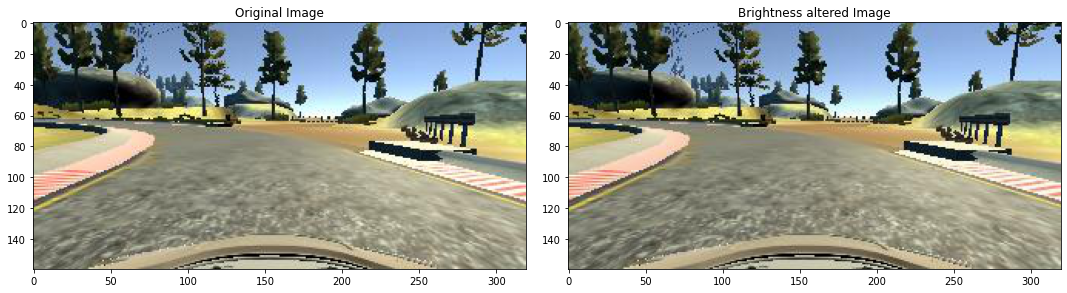

In [48]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10)) # 1 row 2 columns
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered Image')


In [49]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image -  Steering Angle:-0.0')

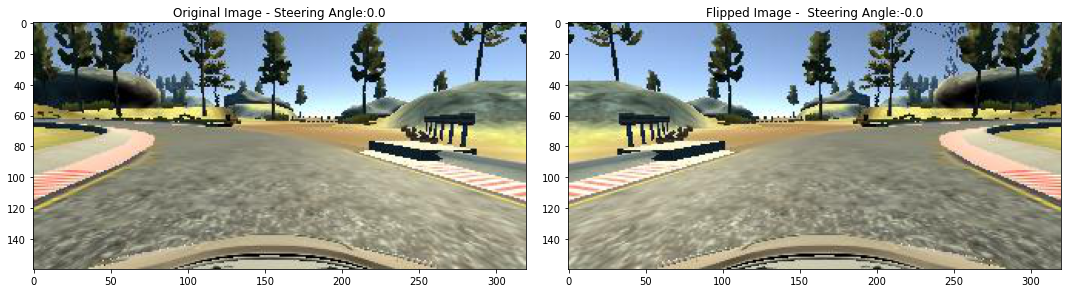

In [50]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

origional_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10)) # 1 row 2 columns
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:'+ str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + ' Steering Angle:' + str(flipped_steering_angle))

In [51]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand()<0.5:
    image = pan(image)
  if np.random.rand()<0.5:
    image = zoom(image)
  if np.random.rand()<0.5:
    image = img_random_brightness(image)
  if np.random.rand()<0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

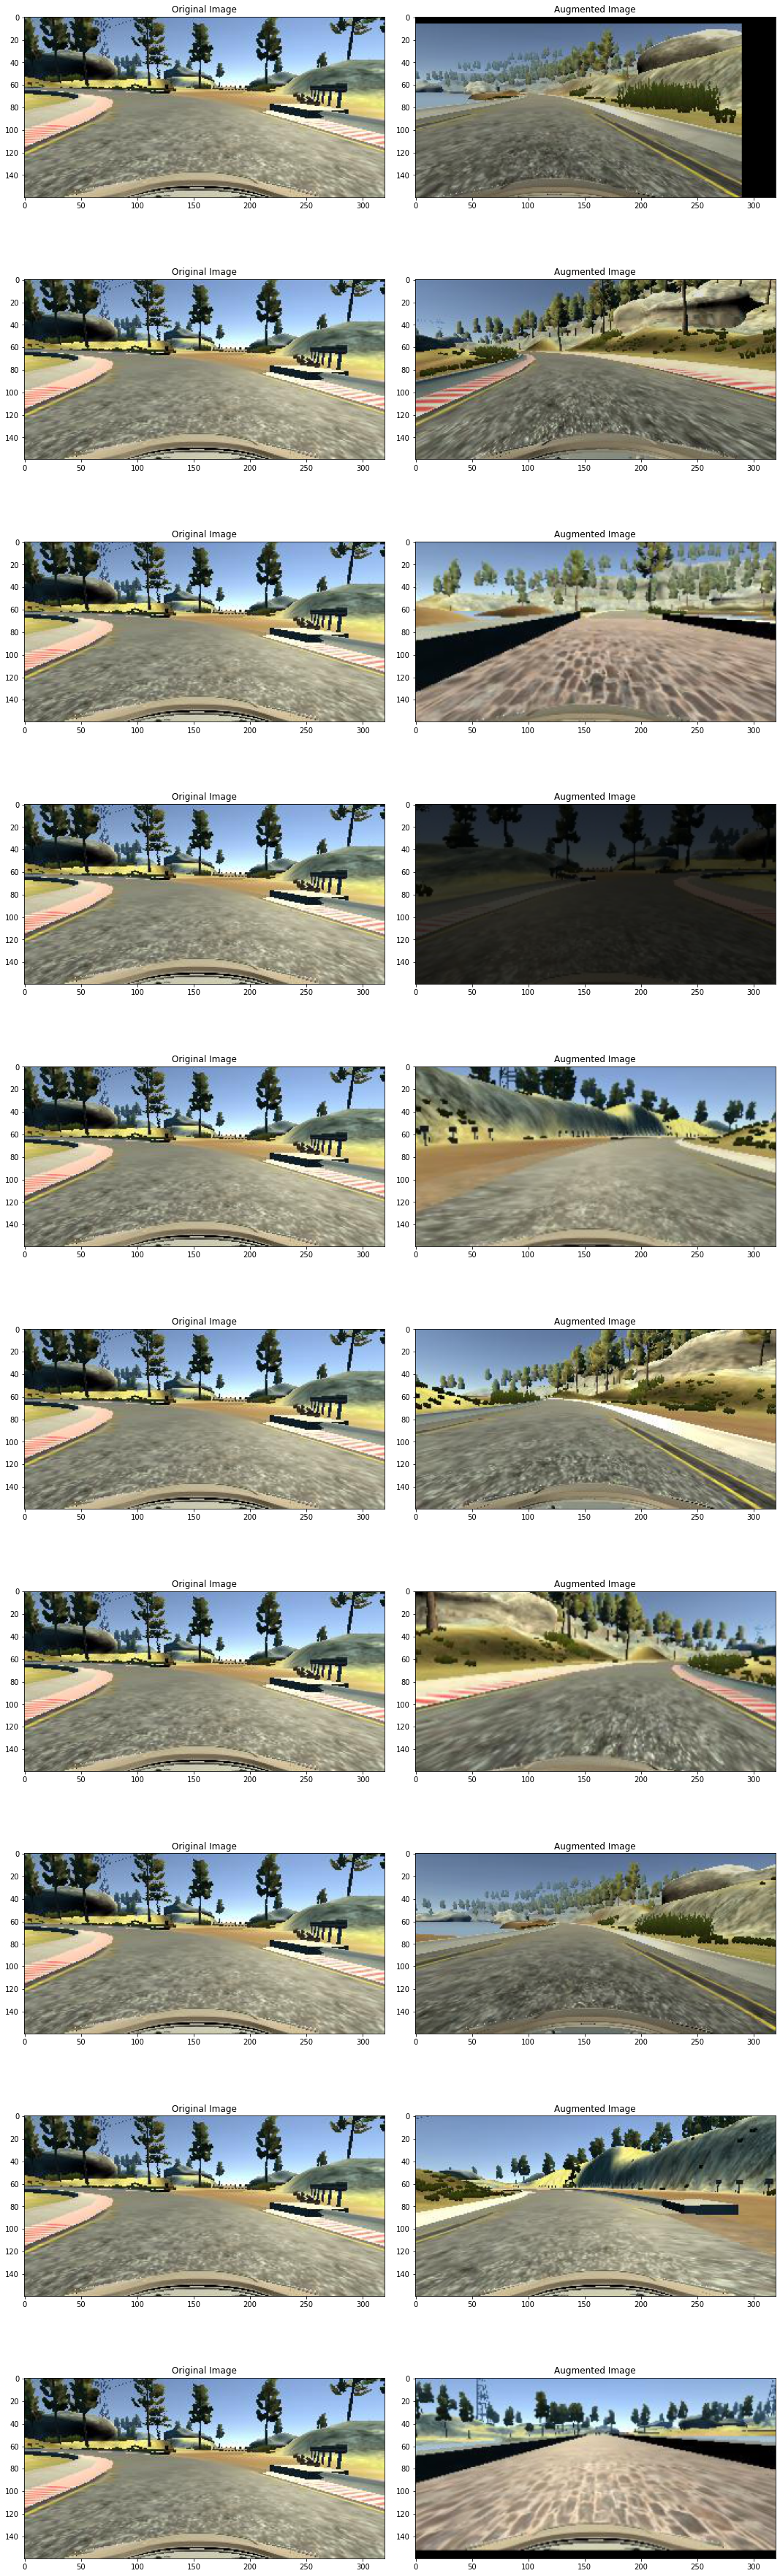

In [52]:
ncol =2 
nrow =10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)# Return a number between the range
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  origional_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  # image sub-package of matplotlib, aliasing it as mpimg for convenience. This sub-package
  # handles matplotlib’s image manipulations. imread method loads our image as a 
  # multi-dimensional NumPy array. imshow displays our image to our screen.
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [53]:
def img_preprocess(img):
  img = img[60:135, :, :]
  # there are many model but we will use NVIDIA model, then we need to convert
  # the color of img to YUV, this color very effective in training NVDA model
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66)) # resize allow for fast computation and eaiser to work with
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed_Image')

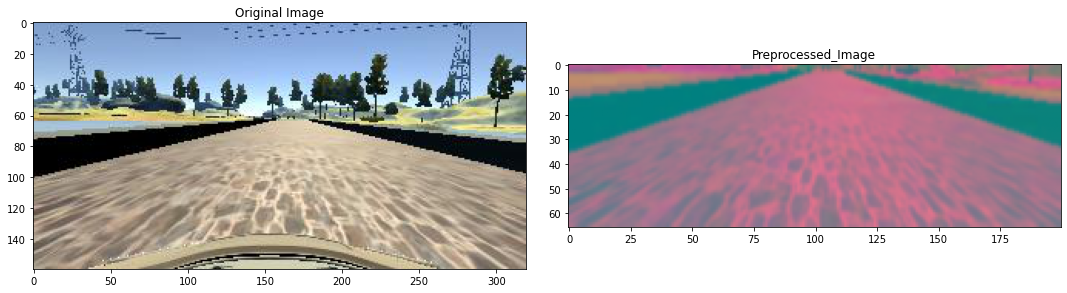

In [54]:
image = image_paths[100] # take the image at position 100
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed_Image')

In [55]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  
# within the batch generator we can preprocess images as required as opposed to preprocessing 
# the entire dataset. This is more memory efficient which is significant when working with a 
# larger dataset. And finally the last of this process is to store our newly augmented and 
# preprocessed image inside of our batch image array or inside of our batch list.

Text(0.5, 1.0, 'Validation Image')

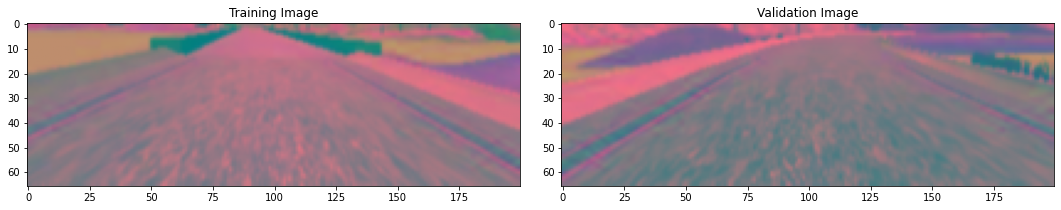

In [56]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
# We use the next statement to request the next batch of images from our generator.
# The next function simply calls an iterator item and retrieves the next item for it.
# within next we call the batch generator and feed it our training day to X train y train we'll define
# a small batch of one just for testing purposes and our training boolean will get a value of 1 as well
# 1 for true as we are dealing with training images.
fig, axs = plt.subplots(1, 2, figsize=(15, 10)) # 1 row 2 columns
fig.tight_layout()
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')
# This actually shifts the image

In [57]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  # because we subsampling 1 pixel at the time, now we use 2x2 
  # to make it quicker. it contains 66x200xU-V images, these images normalize in architecht.
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  #model.add(Dropout(0.5)) # this is not from NVIDEA
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5)) # this is not from NVIDEA

  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5)) # we use agument data so overfitting not an issue so remove drop out
  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(1))
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer = optimizer)
  # now we make sure the modle not overfit our training data
  return model

In [58]:
model = nvidia_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [59]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)
# batch_size =100 because our dataset only 1010 images
# since we will be dealing with a huge augmented dataset, we must generate it on the fly in batches,
# with the generator we just crearted. Thus we also require fit_generator() rather than fit()

Epoch 1/10
300/300 [==============================] - 186s 621ms/step - loss: 0.1914 - val_loss: 0.1563
Epoch 2/10
300/300 [==============================] - 183s 610ms/step - loss: 0.1731 - val_loss: 0.1021
Epoch 3/10
300/300 [==============================] - 183s 610ms/step - loss: 0.1415 - val_loss: 0.0963
Epoch 4/10
300/300 [==============================] - 186s 620ms/step - loss: 0.1270 - val_loss: 0.0942
Epoch 5/10
300/300 [==============================] - 186s 618ms/step - loss: 0.1181 - val_loss: 0.0868
Epoch 6/10
300/300 [==============================] - 185s 616ms/step - loss: 0.1096 - val_loss: 0.1010
Epoch 7/10
300/300 [==============================] - 186s 619ms/step - loss: 0.1035 - val_loss: 0.0883
Epoch 8/10
300/300 [==============================] - 183s 611ms/step - loss: 0.1025 - val_loss: 0.0942
Epoch 9/10
300/300 [==============================] - 183s 609ms/step - loss: 0.0970 - val_loss: 0.0825
Epoch 10/10
300/300 [==============================] - 181s 605m

Text(0.5, 0, 'Epoch')

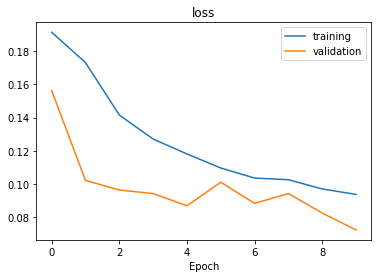

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('Epoch')

In [61]:
model.save('model.h5') # save and download our model.

In [62]:
from google.colab import files
files.download('model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>